**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 17 de octubre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo comprimido con todos los archivos de su solución a este Trabajo Práctico. En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569

# Entregable 1.  Experimentación en Image Colorization

1. El objetivo central es investigar y experimentar en el uso de Deep Learning para la tarea de Image Colorization. En particular pasar de imágenes en escala de grises a imágenes a color.
1. Como dataset puede utilizar ImageWoof (https://docs.ultralytics.com/es/datasets/classify/imagewoof/#dataset-variants)  u otro de su elección. Sobre todo considerando la capacidad de procesamiento de que disponga.
1. Puede usar una biblioteca como OpenCV para obtener las imágenes en escala de grises, o incluso pasar las imágenes iniciales de RGB al espacio de color CIE LAB (el canal L le servirá).
1. Usted debe proponer e implementar el Diseño Experimental, el cual debe considerar al menos tres arquitecturas: dos existentes y una tercer arquitectura propuesta por Usted, no es problema que sea alguna de las dos primeras con algún cambio propuesto por Usted. Es requisito que se programen las capas requeridas para la red neuronal artificial, no usar frameworks que con la llamada a una función retornen el resultado.
1. Es válido utilizar código de alguna fuente como base, pero debe ser citada claramente la fuente.

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import seaborn as sns
import cv2
import tensorflow_io as tfio
import onnxruntime as ort
from collections import defaultdict

from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization


### • Define global size for all our images, we will use this dimensions across our project, it also helps to reduce the resources needed to run the project and unifies the size of all images since in this dataset the images size is not unified

### • Define global batch size for the project, loading and training

In [2]:
images_dimensions = (120, 120)
reshapable_dimension = (120, 120, 1)
local_batch_size = 64
images_to_predict = 10
checkpoints_encoder_decoder_path = 'checkpoints_encoder_decoder_2/colorization_model.h5'
checkpoints_unet_path = 'checkpoints_unet_2/colorization_model.h5'
checkpoints_de2c0_path = 'dummy_checkpoint/colorization_model.h5'
train_epochs_amount = 100

## • Load Dataset

In [3]:
print("Loading train dataset in progess....")

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/train',
    batch_size=local_batch_size,  # Batch size
    image_size=images_dimensions,  # Resize images to the required input size for your model
)

print("Loading train dataset completed!!!")

print("Loading test dataset in progess....")

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './imagewoof2-160/val',
    batch_size=local_batch_size,  # Batch size
    image_size=images_dimensions,  # Resize images to the required input size for your model
)

print("Loading test dataset completed!!!")

Loading train dataset in progess....
Found 9025 files belonging to 10 classes.
Loading train dataset completed!!!
Loading test dataset in progess....
Found 3929 files belonging to 10 classes.
Loading test dataset completed!!!


## • Visualize a few images from training to see they are loading correctly

In [4]:
def visualize_images_lot(images, labels, lot_size = 16, rows = 4, cols= 4, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    for i in range(lot_size): 
        ax = plt.subplot(rows, cols, i + 1)  # Create a rowsxcols grid for displaying images
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy and display
        plt.title(f"Label: {labels[i].numpy()}")  # Show the label    
    plt.show()  # Display the images

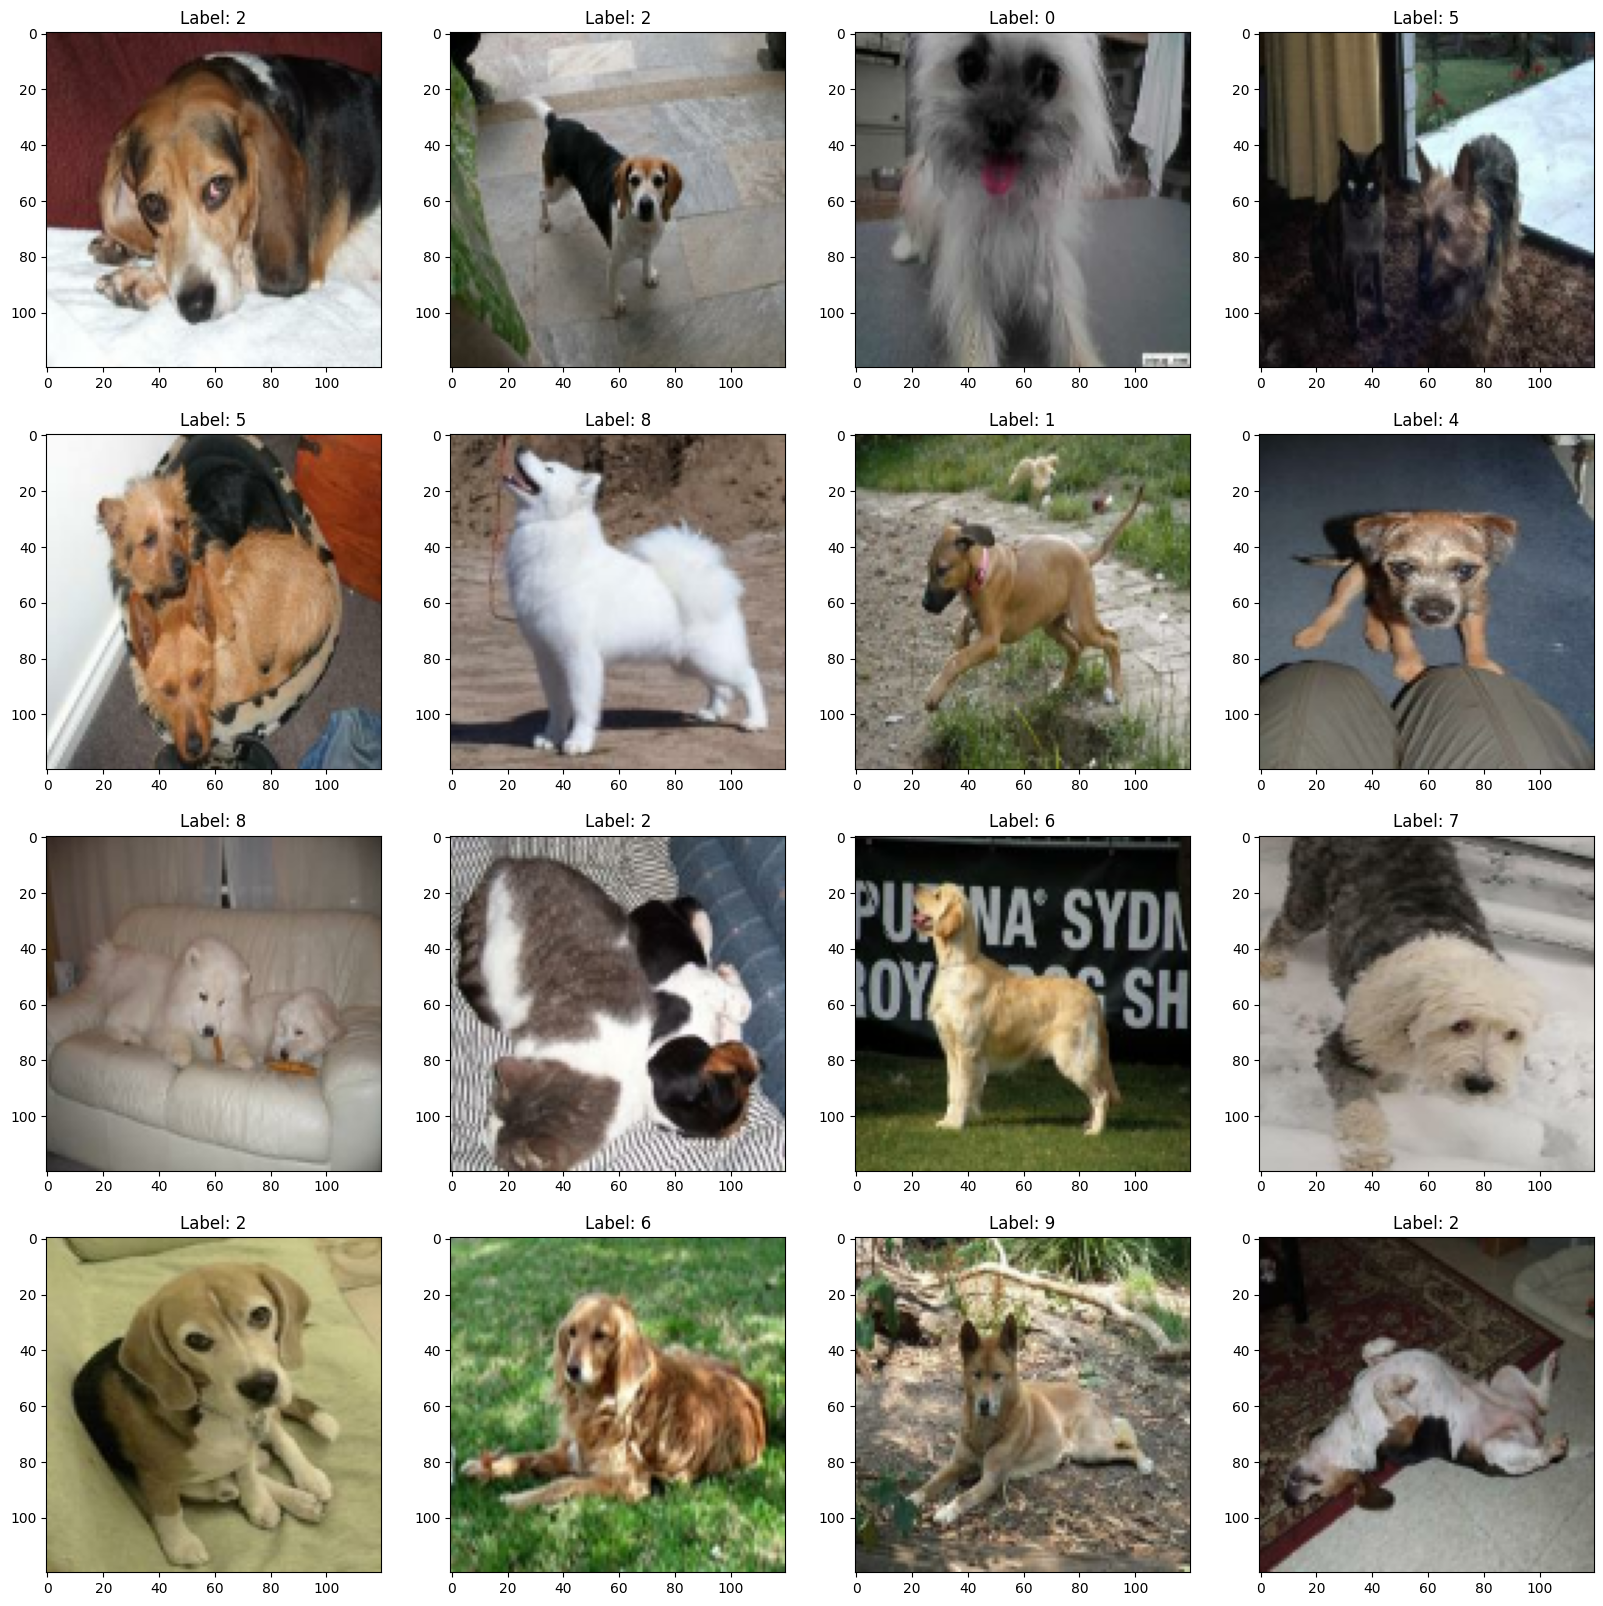

In [5]:
for first_images, first_labels in train_dataset.take(1):
    break
    
visualize_images_lot(first_images, first_labels)

## • Now we will convert our training dataset to grayscale

In [6]:
# Convert RGB image to Lab color space
def rgb_to_lab(image, label):
    normalized_image = image / 255.0
    lab_img = tfio.experimental.color.rgb_to_lab(normalized_image)
    return lab_img, label

In [7]:
# Apply the preprocessing function to the dataset
#train_dataset = train_dataset.map(rgb_to_lab)

## • Now we can plot a few images of our training dataset to the CIELAB color space to see how each channel look

In [8]:
def visualize_images_lot_LAB(images, lot_size = 5, figsize=(10, 10)):
    for i in range(lot_size):
        fig, axs = plt.subplots(1, 3, figsize=(10, 10))
        image_lab = images[i]
    
        axs[0].imshow(image_lab[:, :, 0], cmap='gray')
        axs[0].set_title('L* (Lightness)')

        axs[1].imshow(image_lab[:, :, 1], cmap='RdYlGn')
        axs[1].set_title('a* (Red-Green)')

        axs[2].imshow(image_lab[:, :, 2], cmap='YlGnBu')
        axs[2].set_title('b* (Yellow-Blue)')
    
    plt.show()

In [9]:
# Take the first batch from the dataset already converted to CIELAB
for images, labels in train_dataset.take(1):
    break  # You only need one batch

#visualize_images_lot_LAB(images, 5)

### • In order to have a better handle of the dataset we first unbatch it and handle it as numpy array

In [10]:
train_dataset = train_dataset.unbatch()
train_images = np.asarray(list(train_dataset.map(lambda x, y: x)))

print("Shape of train images", train_images.shape)

Shape of train images (9025, 120, 120, 3)


## • Data normalization

### Note that the grayscale channel (L) normalizes different than the AB channels

In [11]:
#Images only with grayscale channel
#X_grayscale_images = train_images[:, :, :, 0] / 255.0

#Images with AB channels
#y_AB_channels = train_images[:, :, :, 1:] / 128.0

In [12]:
#train_images = train_images / 255.0

## • Show the normalized image to see they are still visible on the LAB channels but in a normalized way

In [13]:
def visualize_images_lot_LAB_Channels(L_channel, AB_channels, lot_size = 5, figsize=(10, 10)):
    for i in range(lot_size):
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        l_channel = L_channel[i]
        ab_channels = AB_channels[i]
    
        axs[0].imshow(l_channel, cmap='gray')
        axs[0].set_title('L* (Lightness)')

        axs[1].imshow(ab_channels[:, :, 0], cmap='RdYlGn')
        axs[1].set_title('a* (Red-Green)')

        axs[2].imshow(ab_channels[:, :, 1], cmap='YlGnBu')
        axs[2].set_title('b* (Yellow-Blue)')
    
    plt.show()

In [14]:
#visualize_images_lot_LAB_Channels(X_grayscale_images,y_AB_channels, 5)

## Architecures 

### • Architecure DE2CO

In [15]:
# Residual block definition
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # Single convolutional layer in this smaller version
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Adjust the shortcut connection in case the input and output dimensions differ
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Add the shortcut connection to the output
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# Smaller Encoder-Decoder model with skip connections
def create_DE2CO_model(input_shape=reshapable_dimension):
    inputs = layers.Input(shape=input_shape)

    # Smaller Encoder: Fewer residual blocks and filters
    x = residual_block(inputs, 16)   # Reduced filters
    x = residual_block(x, 32)
    encoded = residual_block(x, 64)

    # Smaller Decoder: Fewer layers and filters
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final upsampling layer to output 3-channel RGB image
    outputs = layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)

    # Define the model
    model = models.Model(inputs, outputs)

    return model

### For this architecture first we need to create RGB-D images, for this we will use a model already created just to obtain the RGB-D of a RGB image

(120, 120)


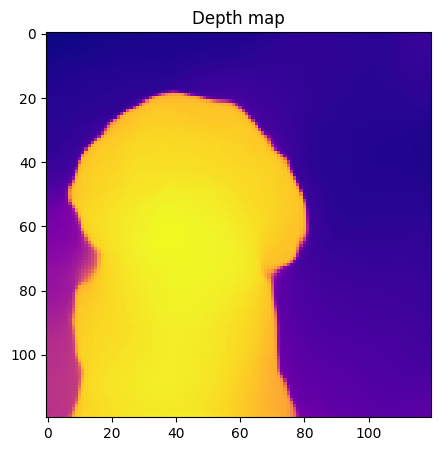

In [16]:
# Load the ONNX model for MiDaS
onnx_model_path = "midas_v21_small_256.onnx"  # Make sure you have the ONNX model file
ort_session = ort.InferenceSession(onnx_model_path)

# Preprocess the input image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))  # Resize to input size required by MiDaS model
    img = img.astype(np.float32) / 255.0  # Normalize image
    img = np.transpose(img, (2, 0, 1))  # Change to (channels, height, width)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Run depth estimation using ONNX model
def estimate_depth(img):
    input_image = preprocess_image(img)
    #print("Input image", input_image)
    input_name = ort_session.get_inputs()[0].name
    #print("Input name", input_name)
    depth_map = ort_session.run(None, {input_name: input_image})[0]
    #print("Depth map", depth_map.shape)
    
    # Postprocess depth map (for visualization)
    depth_map = depth_map.squeeze()

    # Resize the depth map to (120, 120)
    depth_map = cv2.resize(depth_map, (120, 120), interpolation=cv2.INTER_LINEAR)
    
    depth_map = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))  # Normalize depth map
    #print("Depth map normalized", depth_map)
    return depth_map

# Example usage
depth_map = estimate_depth(train_images[0])

# Visualize the depth map using OpenCV
#fig, axs = plt.subplots(1, 1, figsize=(10, 10))
#axs[0].imshow(depth_map)
#axs[0].set_title('Depth map')

print(depth_map.shape)
plt.figure(figsize=(5,5))
ax = plt.subplot(1, 1, 1)  # Create a rowsxcols grid for displaying images
plt.imshow(depth_map, cmap='plasma')  # Convert tensor to numpy and display
plt.title("Depth map")  # Show the label    
plt.show()  # Display the images

In [17]:
# Training the model
def train_model(model, X_train, y_train, batch_size=64, epochs=50, checkpoint_dir=''):
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'Precision'])

    # Create checkpoints folder
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'colorization_model.h5'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_cb])
    return history

In [18]:
def estimated_depths(data_images):
    # Loop over the dataset and apply the function to each image
    estimated_depths_array = np.zeros((data_images.shape[0], 120, 120, 1))
    for i in range(data_images.shape[0]):
        estimated_depths_array[i] = estimate_depth(data_images[i]).reshape(120, 120, 1)
        if i % 1000 == 0:
            print("Loading ", i)
    print("Finished!!!")
    print(estimated_depths_array[0])
    print(estimated_depths_array.shape)
    return estimated_depths_array

train_depth_estimations = estimated_depths(train_images)

Loading  0
Loading  1000
Loading  2000
Loading  3000
Loading  4000
Loading  5000
Loading  6000
Loading  7000
Loading  8000
Loading  9000
Finished!!!
[[[4.18741511e-05]
  [0.00000000e+00]
  [4.06540552e-04]
  ...
  [7.61631355e-02]
  [7.72301704e-02]
  [7.44303316e-02]]

 [[1.75705377e-03]
  [1.74856256e-03]
  [1.62368163e-03]
  ...
  [7.60224015e-02]
  [7.64425471e-02]
  [7.82485530e-02]]

 [[3.56977130e-03]
  [3.96047812e-03]
  [4.19866340e-03]
  ...
  [7.72994980e-02]
  [7.68755004e-02]
  [7.92333186e-02]]

 ...

 [[4.31532264e-01]
  [4.24877495e-01]
  [4.30672914e-01]
  ...
  [1.63181916e-01]
  [1.64352268e-01]
  [1.66550994e-01]]

 [[4.34033066e-01]
  [4.27631199e-01]
  [4.35527325e-01]
  ...
  [1.66591868e-01]
  [1.68115467e-01]
  [1.72478974e-01]]

 [[4.39138561e-01]
  [4.32270259e-01]
  [4.35554624e-01]
  ...
  [1.67271093e-01]
  [1.69176504e-01]
  [1.75103173e-01]]]
(9025, 120, 120, 1)


In [19]:
normalized_train_images = train_images / 255.0

### Load the DE2CO model if esxists, if not create a new one.
### Show a summary of the DE2CO architecture

In [20]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_DE2CO_loaded_from_disk = False

if os.path.isfile(checkpoints_de2c0_path):
    print("Loading saved DE2CO model!!!")
    de2co_model = tf.keras.models.load_model(checkpoints_de2c0_path)
    was_DE2CO_loaded_from_disk = True
else:
    print("Creating DE2CO model!!!")
    de2co_model = create_DE2CO_model(reshapable_dimension)
    
de2co_model.summary()

Creating DE2CO model!!!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 120, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                     

In [21]:
def visualize_metrics(history, under_lim = -2, upper_lim = 2):
    pd.DataFrame(history.history).plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(under_lim, upper_lim)
    plt.xlabel("epochs")
    plt.show()

Epoch 1/100
113/113 [==============================] - 242s 2s/step - loss: 0.0635 - accuracy: 0.5245 - precision: 0.9978 - val_loss: 0.0647 - val_accuracy: 0.5869 - val_precision: 0.9966
Epoch 2/100
113/113 [==============================] - 247s 2s/step - loss: 0.0619 - accuracy: 0.5424 - precision: 0.9980 - val_loss: 0.0648 - val_accuracy: 0.5853 - val_precision: 0.9962
Epoch 3/100
113/113 [==============================] - 247s 2s/step - loss: 0.0615 - accuracy: 0.5501 - precision: 0.9982 - val_loss: 0.0653 - val_accuracy: 0.5500 - val_precision: 0.9966
Epoch 4/100
113/113 [==============================] - 244s 2s/step - loss: 0.0615 - accuracy: 0.5526 - precision: 0.9980 - val_loss: 0.0647 - val_accuracy: 0.4502 - val_precision: 0.9979
Epoch 5/100
113/113 [==============================] - 251s 2s/step - loss: 0.0613 - accuracy: 0.5559 - precision: 0.9981 - val_loss: 0.1002 - val_accuracy: 0.3339 - val_precision: 0.9964
Epoch 6/100
113/113 [==============================] - 249s 

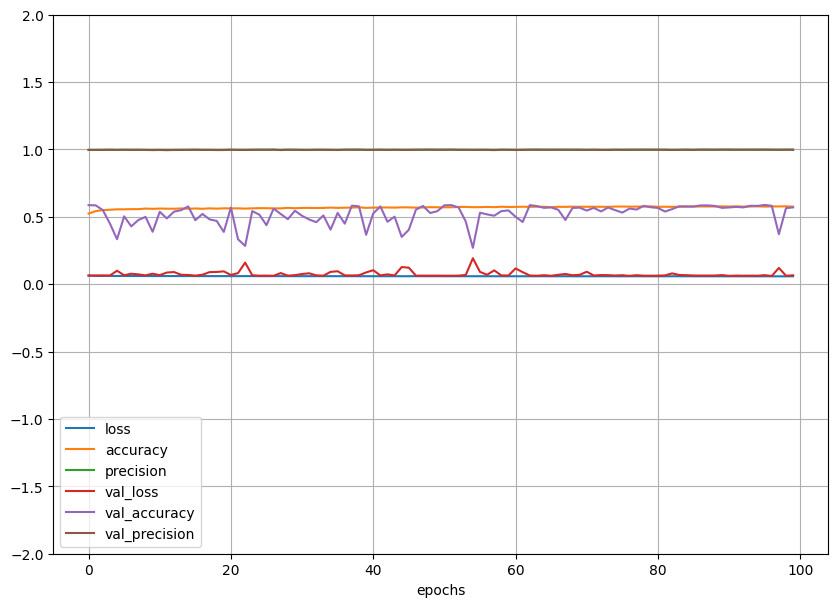

In [22]:
if was_DE2CO_loaded_from_disk is False:
    history = train_model(de2co_model, train_depth_estimations, normalized_train_images, batch_size=local_batch_size, epochs=train_epochs_amount, checkpoint_dir=checkpoints_de2c0_path)
    visualize_metrics(history)

## * Test phase

### * Here we will compare the 3 architectures *

### • We start by mapping the the test data to LAB format since we will need to generate grayscale of these images and then replace its AB channels with the predicted ones

In [23]:
#test_dataset = test_dataset.map(rgb_to_lab)

In [24]:
test_dataset_lab = test_dataset.unbatch()
test_dataset_lab_images = np.asarray(list(test_dataset_lab.map(lambda x, y: x)))

print("Shape of val LAB images: ", test_dataset_lab_images.shape)

Shape of val LAB images:  (3929, 120, 120, 3)


In [25]:
estimeated_depths_test_data = estimated_depths(test_dataset_lab_images)

Loading  0
Loading  1000
Loading  2000
Loading  3000
Finished!!!
[[[0.9319247 ]
  [0.91077977]
  [0.91144699]
  ...
  [0.02911378]
  [0.0288926 ]
  [0.02813018]]

 [[0.91314387]
  [0.89718622]
  [0.90158099]
  ...
  [0.03091112]
  [0.03087556]
  [0.03018177]]

 [[0.91470295]
  [0.90315676]
  [0.90141928]
  ...
  [0.03240024]
  [0.03283543]
  [0.03234566]]

 ...

 [[0.9048146 ]
  [0.88818073]
  [0.88799727]
  ...
  [0.95136738]
  [0.94993192]
  [0.99278367]]

 [[0.91380924]
  [0.89673746]
  [0.89683342]
  ...
  [0.95642924]
  [0.9545235 ]
  [0.9942531 ]]

 [[0.92382306]
  [0.90710443]
  [0.90732926]
  ...
  [0.96973109]
  [0.96832871]
  [1.        ]]]
(3929, 120, 120, 1)


### • Now we can start predcting from grayscale channels to RGB

In [26]:
def predict_RGB_image(depth_image, model):
    reshape_depth_image = depth_image.reshape(1 , depth_image.shape[0], depth_image.shape[1], 1)
    rgb_image = model.predict(reshape_depth_image)
    #rgb_image = rgb_image[0] * 255.0
    rgb_image = rgb_image[0]
    return rgb_image

In [27]:
def lot_predictions(depth_images, model, lot_size = 5):
    predictions_lot = []
    for i in range(lot_size):
        predictions_lot.append(predict_RGB_image(depth_images[i], model))
    return predictions_lot

### We predict a few of the first images of our test data, to se how is predicting

In [28]:
print("Predict using the de2co model")
de2co_predictions = lot_predictions(estimeated_depths_test_data, de2co_model, images_to_predict)

Predict using the de2co model
1/1 [==============================] - 0s 47ms/step


### • Now let's plot our predictions

DE2CO Predictions
(120, 120)
(120, 120, 3)


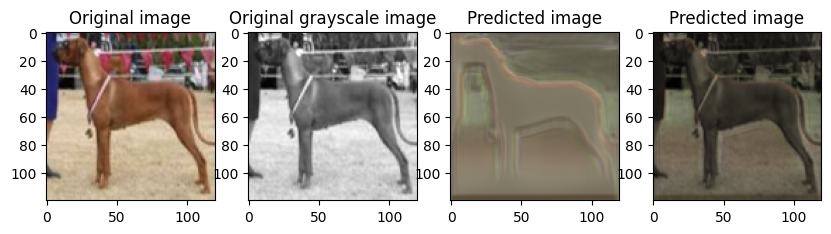

(120, 120)
(120, 120, 3)


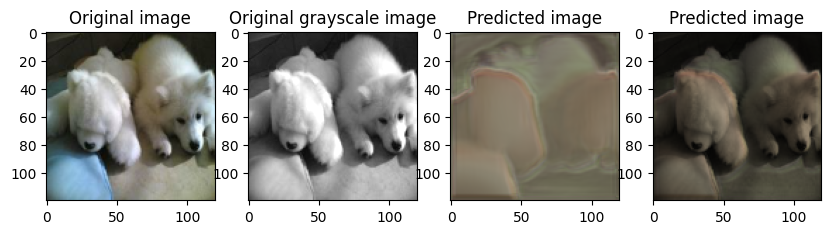

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01063202136598637..1.0075416678356668].


(120, 120)
(120, 120, 3)


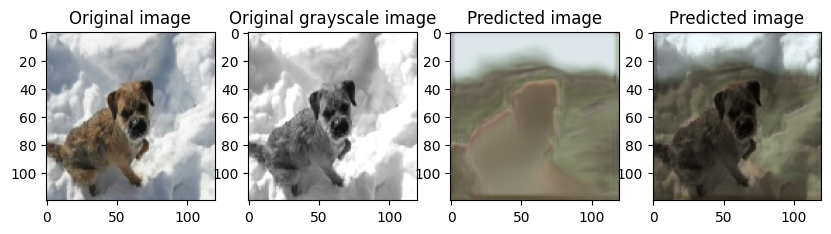

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0746361103735165].


(120, 120)
(120, 120, 3)


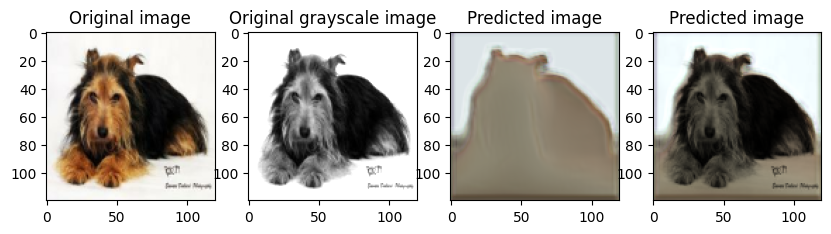

(120, 120)
(120, 120, 3)


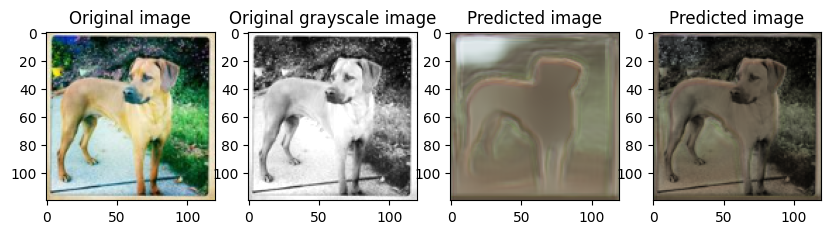

In [29]:
#print(de2co_predictions)
print("DE2CO Predictions")
#print(de2co_predictions[0])

#plt.show()


for i in range(5):
    fig, axs = plt.subplots(1, 4, figsize=(10, 10))

    axs[0].imshow(test_dataset_lab_images[i] / 255.0)
    axs[0].set_title('Original image')
    
    grayscale_image = np.dot(test_dataset_lab_images[i] / 225.0, [0.2989, 0.5870, 0.1140])
    
    axs[1].imshow(grayscale_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    axs[1].set_title('Original grayscale image')
    
    
    #print(grayscale_image)
    
    #plt.imshow(grayscale_image * de2co_predictions[i])
    #plt.imshow(de2co_predictions[i])
    axs[2].imshow(de2co_predictions[i])
    axs[2].set_title('Predicted image')

    print(grayscale_image.shape)
    array_3d = np.stack([grayscale_image]*3, axis=-1)

    print(array_3d.shape)
    
    axs[3].imshow(array_3d * de2co_predictions[i])
    axs[3].set_title('Predicted image')
    
    plt.show()


#visualize_images_lot_LAB_Channels(test_images_grayscale, encoder_decoder_predictions, images_to_predict)

### • Now let's plot what it was expected in terms of channels

In [30]:
visualize_images_lot_LAB_Channels(test_images_grayscale, test_images_AB_channels, images_to_predict)

NameError: name 'test_images_grayscale' is not defined

### • Finally we compare the original image vs the predicted one in RGB format to see the differences

In [ ]:
# Convert LAB to RGB
def lab_to_rgb(lab_img):
    rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    return rgb_img

In [ ]:
def compare_original_vs_predicted(original_test_image, predicted_AB_channels, lot_size = 5, figsize=(15, 15)):
    for i in range(lot_size):
        fig, axs = plt.subplots(1, 3, figsize=figsize)

        original_test_image_rgb = lab_to_rgb(original_test_image[i])
    
        axs[0].imshow(cv2.cvtColor(original_test_image_rgb, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original test image')


        original_test_image[i, :, :, 1:] = predicted_AB_channels[0][i]  # Replace AB channels in the original LAB image

        predicted_image_rgb = lab_to_rgb(original_test_image[i])
        

        axs[1].imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Predicted image with encoder-decoder')

        original_test_image[i, :, :, 1:] = predicted_AB_channels[1][i]  # Replace AB channels in the original LAB image

        predicted_image_rgb = lab_to_rgb(original_test_image[i])

        axs[2].imshow(cv2.cvtColor(predicted_image_rgb, cv2.COLOR_BGR2RGB))
        axs[2].set_title('Predicted image with U-Net')
        
        
        plt.show()

In [ ]:
compare_original_vs_predicted(test_dataset_lab_images, [encoder_decoder_predictions, UNet_predictions], images_to_predict)